In [84]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils.evaluation import (
    get_all_test_data,
    get_table_column_names
)

In [85]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [86]:
colors = ['#ff8b94', '#a8e6cf', '#70bbff']

In [87]:
sns.set_palette("pastel")

In [88]:
font_size_title = 16
font_size = 12
labelpad = 20

In [89]:
llms = ["oll_gemma_instruct", "oll_llama3_instruct", "oll_mistral_instruct"]
collections = {
    "wiki_movie_plots_512_50_mxbai": "Wiki Movie Plots 512 50",
    "wiki_movie_plots_1024_100_mxbai": "Wiki Movie Plots 1024 100",
    "wiki_movie_plots_2048_200_mxbai": "Wiki Movie Plots 2048 200"
}
collections_keys = [*collections.keys()]
collections_values = [*collections.values()]

metrics = {
    "context_relevancy_score": "Context Relevancy Score",
    "correctness_score": "Correctness Score",
    "faithfulness_score": "Faithfulness Score",
    "relevancy_score": "Relevancy Score",
    "model_score": "Model Score"
}
metrics_keys = [*metrics.keys()]
metrics_values = [*metrics.values()]
labels_llms = {
    "oll_gemma_instruct": "Gemma Instruct",
    "oll_llama3_instruct": "Llama3 Instruct",
    "oll_mistral_instruct": "Mistral Instruct"
}
labels_llms_keys = [*labels_llms.keys()]
labels_llms_values = [*labels_llms.values()]
chat_mode = "CONTEXT"

In [90]:
def barplot_by_model_and_collection(df, metric, with_llms=True, x_label="", width=14, height=7, reordered_colors=colors):
    # init plot figure
    plt.figure(figsize=(width, height))

    # create a bar plot object
    if with_llms:
        bar_plot = sns.barplot(data=df, x='collection_name', y=metric, hue='llm_model', palette=colors)
        suffix_title = " LLM and Collection"
    else:
        bar_plot = sns.barplot(data=df, x='collection_name', y=metric, hue='collection_name', palette=colors)
        suffix_title = " Collection"

    # set the title and labels
    plt.title(f'Distribution of {metrics[metric]} by{suffix_title}', fontsize=font_size_title, fontweight='bold',
              pad=labelpad)
    plt.xlabel(x_label, fontsize=font_size, fontweight='bold', labelpad=labelpad)
    plt.ylabel(metrics[metric], fontsize=font_size, fontweight='bold', labelpad=labelpad)

    # add horizontal gridlines for mean values
    for i, collection in enumerate(collections_keys):
        print(f'Collection: {collection}')
        mean_value = df[df['collection_name'] == collection][metric].mean()
        bar_plot.axhline(mean_value, color=colors[i], linestyle='--', linewidth=1.5)
        # add the mean value as text
        bar_plot.text(i, mean_value + 0.05, f'{mean_value:.2f}', color=reordered_colors[i], ha='center', fontsize=10,
                      fontweight='bold')

    # set the x-axis labels
    bar_plot.set_xticklabels(collections_values, fontsize=font_size)

    # legend
    handles, labels = bar_plot.get_legend_handles_labels()
    if with_llms:
        new_labels = []
        for label in labels:
            new_labels.append(labels_llms[label])
        bar_plot.legend(
            handles=handles,
            labels=new_labels,
            title='LLM Models',
            fontsize=10,
            bbox_to_anchor=(1, -.1)
        )
    else:
        bar_plot.legend(
            handles=handles,
            labels=labels,
            title='Collections',
            fontsize=10,
            bbox_to_anchor=(1, -.1)
        )

    # Show the plot
    plt.show()

In [130]:
def horizontal_barplot_by_model_and_collection(df_pivot, metric, x_label="Number of Records per ", y_label="LLMs Models per Collections"):
    df_plot = df_pivot.plot(
        kind='barh',
        stacked=True,
        figsize=(12, 7),
        color=colors
    )

    set_x_label=f"{x_label}{metrics[metric]}"
    
    # set the title and labels
    df_plot.set_xlabel(set_x_label, fontsize=font_size,
                       fontweight='bold', labelpad=labelpad)
    df_plot.set_ylabel(y_label, fontsize=font_size, fontweight='bold',
                       labelpad=labelpad)
    df_plot.set_title(f'Distribution of {metrics[metric]} by LLM Models and Collections',
                      fontsize=font_size_title, fontweight='bold', pad=labelpad)
    df_plot.legend(title=metrics[metric], fontsize=10, bbox_to_anchor=(1, -.1))

    ytick_labels = [label.get_text() for label in df_plot.get_yticklabels()]
    df_plot_collections = df_pivot['collection_name'].to_list()
    new_ytick_labels = []
    for label in ytick_labels:
        model_key = df_pivot['llm_model'][int(label)]
        collection_key = df_plot_collections[int(label)]
        new_label = f'{labels_llms[model_key]} ({collections[collection_key][17:].replace(" ", "/")})'
        new_ytick_labels.append(new_label)
    df_plot.set_yticklabels(new_ytick_labels, fontsize=font_size)

    # add line for maximum of numbers
    df_plot.axvline(x=315, linestyle='-', color='black', linewidth=0.8)
    df_plot.text(315 + 4, 3.5, f'315', color='black', ha='left', fontsize=11, fontweight='bold')

    # add lines for the mean values
    for i, rows in enumerate(ytick_labels):
        # get the values for the current row
        df_pivot_row = df_pivot.iloc[i]
        text_zero = df_pivot_row[0.0]
        df_plot.text((text_zero/2) if text_zero > 40 else 5, i - .1, text_zero, color='black', ha='center', fontsize=10)
        text_one = df_pivot_row[1.0]
        if 0.5 in df_pivot.columns:
            text_half = df_pivot_row[0.5]
            df_plot.text(text_zero + (text_half/2), i - .1, text_half, color='black', ha='center', fontsize=10)
            df_plot.text((text_zero + text_half + (text_one/2) ) if text_one > 40 else 300, i - .1, text_one, color='black', ha='center', fontsize=10)
        else:
            df_plot.text(text_zero + (text_one/2), i - .1, text_one, color='black', ha='center', fontsize=10)


In [92]:
column_names = get_table_column_names(table_name="evaluation")

In [93]:
all_records_a = get_all_test_data(llm=False, collection_name="wiki_movie_plots_512_50_mxbai", chat_mode='CONTEXT')
all_records_b = get_all_test_data(llm=False, collection_name="wiki_movie_plots_1024_100_mxbai", chat_mode='CONTEXT')
all_records_c = get_all_test_data(llm=False, collection_name="wiki_movie_plots_2048_200_mxbai", chat_mode='CONTEXT')

In [94]:
data_without_id_a = [t[1:] for t in all_records_a]
data_without_id_b = [t[1:] for t in all_records_b]
data_without_id_c = [t[1:] for t in all_records_c]

In [95]:
ids_only_a = [t[0] for t in all_records_a]
ids_only_b = [t[0] for t in all_records_b]
ids_only_c = [t[0] for t in all_records_c]

In [96]:
df_a = pd.DataFrame(data=data_without_id_a, index=ids_only_b, columns=column_names[1:])
df_b = pd.DataFrame(data=data_without_id_b, index=ids_only_b, columns=column_names[1:])
df_c = pd.DataFrame(data=data_without_id_c, index=ids_only_c, columns=column_names[1:])

In [97]:
df_a.head()

,llm_model,embed_model,collection_name,question_id,question,context,reference_answer,response,answer_feedback,context_relevancy_score,context_relevancy_feedback,correctness_score,correctness_feedback,faithfulness_score,relevancy_score,relevancy_feedback,model_score,model_feedback,chat_mode
1072,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,0,"Who is the director of the movie ""The Karate K...",release_year: 1984\ntitle: The Karate Kid\nori...,"The director of the movie ""The Karate Kid"" rel...","According to the context information provided,...","1. Yes, the response matches the subject matte...",1.0,1. The retrieved context matches the subject m...,4.5,The generated answer is relevant and fully cor...,1.0,1.0,YES,1.0,Assistant A and Assistant B both correctly ide...,CONTEXT
1073,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,1,"What is the plot of ""The Karate Kid"" released ...",release_year: 1984\ntitle: The Karate Kid\nori...,"The plot of ""The Karate Kid"" released in 1984 ...","According to the context information provided,...",1. Does the provided response match the subjec...,1.0,1. The retrieved context matches the subject m...,3.5,The generated answer provides a detailed summa...,1.0,1.0,YES,1.0,Assistant A provided a detailed and comprehens...,CONTEXT
1074,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,2,"What is the genre of the movie ""The Karate Kid...",release_year: 1984\ntitle: The Karate Kid\nori...,"The genre of the movie ""The Karate Kid"" releas...","According to the context information provided,...",1. Does the provided response match the subjec...,1.0,1. The retrieved context matches the subject m...,4.5,The generated answer is relevant and fully cor...,0.0,1.0,YES,0.0,Assistant B provided a slightly better respons...,CONTEXT
1075,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,3,Who was the legendary boxing trainer that took...,release_year: 2016\ntitle: Hands of Stone\nori...,"Ray Arcel, an American legendary boxing traine...","According to the context information provided,...",1. The response correctly identifies Ray Arcel...,1.0,1. The retrieved context matches the subject m...,4.5,The generated answer is highly relevant to the...,1.0,1.0,YES,1.0,Assistant A provided a direct and accurate res...,CONTEXT
1076,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,4,What was the result of the rematch between Rob...,release_year: 2016\ntitle: Hands of Stone\nori...,"Durán famously gave up by saying ""No más"" to t...","According to the context information provided,...",1. The response matches the subject matter of ...,1.0,1. The retrieved context matches the subject m...,4.5,The generated answer provides a detailed and a...,1.0,1.0,YES,1.0,Assistant A provided a more detailed and compr...,CONTEXT


In [98]:
df_b.head()

,llm_model,embed_model,collection_name,question_id,question,context,reference_answer,response,answer_feedback,context_relevancy_score,context_relevancy_feedback,correctness_score,correctness_feedback,faithfulness_score,relevancy_score,relevancy_feedback,model_score,model_feedback,chat_mode
1072,oll_llama3_instruct,mxbai,wiki_movie_plots_1024_100_mxbai,0,"Who is the director of the movie ""The Karate K...",release_year: 1984\ntitle: The Karate Kid\nori...,"The director of the movie ""The Karate Kid"" rel...","According to the context information provided,...",1. Does the provided response match the subjec...,1.0,1. The retrieved context matches the subject m...,5.0,The generated answer is both relevant and corr...,1.0,1.0,YES,1.0,Assistant A provided a more comprehensive resp...,CONTEXT
1073,oll_llama3_instruct,mxbai,wiki_movie_plots_1024_100_mxbai,1,"What is the plot of ""The Karate Kid"" released ...",release_year: 1984\ntitle: The Karate Kid\nori...,"The plot of ""The Karate Kid"" released in 1984 ...","Here's the plot of ""The Karate Kid"" (1984):\n\...",1. Does the provided response match the subjec...,1.0,1. The retrieved context matches the subject m...,4.0,The generated answer provides a detailed and a...,1.0,1.0,YES,1.0,Assistant A provides a detailed and comprehens...,CONTEXT
1074,oll_llama3_instruct,mxbai,wiki_movie_plots_1024_100_mxbai,2,"What is the genre of the movie ""The Karate Kid...",release_year: 1984\ntitle: The Karate Kid\nori...,"The genre of the movie ""The Karate Kid"" releas...","The genre of the movie ""The Karate Kid"" releas...",1. The response provided matches the subject m...,1.0,1. The retrieved context matches the subject m...,4.0,"The generated answer is relevant and correct, ...",1.0,1.0,YES,1.0,Assistant A provided a more detailed and compr...,CONTEXT
1075,oll_llama3_instruct,mxbai,wiki_movie_plots_1024_100_mxbai,3,Who was the legendary boxing trainer that took...,release_year: 2016\ntitle: Hands of Stone\nori...,"Ray Arcel, an American legendary boxing traine...","According to the context information, the lege...",1. The response correctly identifies Ray Arcel...,1.0,1. The retrieved context matches the subject m...,4.5,The generated answer is highly relevant to the...,1.0,1.0,YES,0.5,,CONTEXT
1076,oll_llama3_instruct,mxbai,wiki_movie_plots_1024_100_mxbai,4,What was the result of the rematch between Rob...,release_year: 2016\ntitle: Hands of Stone\nori...,"Durán famously gave up by saying ""No más"" to t...","According to the context information, in the r...",1. The response provided matches the subject m...,1.0,1. The retrieved context matches the subject m...,4.5,The generated answer is highly relevant to the...,1.0,1.0,YES,1.0,Assistant A provided a more detailed and accur...,CONTEXT


In [99]:
df_c.head()

,llm_model,embed_model,collection_name,question_id,question,context,reference_answer,response,answer_feedback,context_relevancy_score,context_relevancy_feedback,correctness_score,correctness_feedback,faithfulness_score,relevancy_score,relevancy_feedback,model_score,model_feedback,chat_mode
2962,oll_llama3_instruct,mxbai,wiki_movie_plots_2048_200_mxbai,0,"Who is the director of the movie ""The Karate K...",release_year: 1984\ntitle: The Karate Kid\nori...,"The director of the movie ""The Karate Kid"" rel...","According to the context information provided,...","1. Yes, the response directly addresses the qu...",1.0,1. The retrieved context matches the subject m...,4.5,The generated answer is highly relevant to the...,1.0,1.0,YES,1.0,Assistant A provided a more comprehensive resp...,CONTEXT
2963,oll_llama3_instruct,mxbai,wiki_movie_plots_2048_200_mxbai,1,"What is the plot of ""The Karate Kid"" released ...",release_year: 1984\ntitle: The Karate Kid\nori...,"The plot of ""The Karate Kid"" released in 1984 ...","According to the context information provided,...",1. Does the provided response match the subjec...,1.0,1. The retrieved context matches the subject m...,4.5,The generated answer provides a detailed and a...,1.0,1.0,YES,1.0,Assistant A provides a detailed and comprehens...,CONTEXT
2964,oll_llama3_instruct,mxbai,wiki_movie_plots_2048_200_mxbai,2,"What is the genre of the movie ""The Karate Kid...",release_year: 1984\ntitle: The Karate Kid\nori...,"The genre of the movie ""The Karate Kid"" releas...","According to the context information provided,...",1. Does the provided response match the subjec...,1.0,1. The retrieved context matches the subject m...,4.5,The generated answer is relevant to the user q...,0.0,1.0,YES,0.0,Assistant B provided a more comprehensive and ...,CONTEXT
2965,oll_llama3_instruct,mxbai,wiki_movie_plots_2048_200_mxbai,3,Who was the legendary boxing trainer that took...,release_year: 2016\ntitle: Hands of Stone\nori...,"Ray Arcel, an American legendary boxing traine...","According to the context information provided,...",1. The response correctly identifies Ray Arcel...,1.0,1. The retrieved context matches the subject m...,4.5,The generated answer is highly relevant to the...,1.0,1.0,YES,0.0,Assistant A correctly identifies the legendary...,CONTEXT
2966,oll_llama3_instruct,mxbai,wiki_movie_plots_2048_200_mxbai,4,What was the result of the rematch between Rob...,release_year: 2016\ntitle: Hands of Stone\nori...,"Durán famously gave up by saying ""No más"" to t...","According to the context information provided,...",1. The provided response matches the subject m...,1.0,1. The retrieved context matches the subject m...,4.5,The generated answer is highly relevant to the...,1.0,1.0,YES,0.0,None,CONTEXT


In [100]:
df_combined = pd.concat([df_a, df_b, df_c], ignore_index=True)
df_combined

,llm_model,embed_model,collection_name,question_id,question,context,reference_answer,response,answer_feedback,context_relevancy_score,context_relevancy_feedback,correctness_score,correctness_feedback,faithfulness_score,relevancy_score,relevancy_feedback,model_score,model_feedback,chat_mode
0,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,0,"Who is the director of the movie ""The Karate K...",release_year: 1984\ntitle: The Karate Kid\nori...,"The director of the movie ""The Karate Kid"" rel...","According to the context information provided,...","1. Yes, the response matches the subject matte...",1.000,1. The retrieved context matches the subject m...,4.5,The generated answer is relevant and fully cor...,1.0,1.0,YES,1.0,Assistant A and Assistant B both correctly ide...,CONTEXT
1,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,1,"What is the plot of ""The Karate Kid"" released ...",release_year: 1984\ntitle: The Karate Kid\nori...,"The plot of ""The Karate Kid"" released in 1984 ...","According to the context information provided,...",1. Does the provided response match the subjec...,1.000,1. The retrieved context matches the subject m...,3.5,The generated answer provides a detailed summa...,1.0,1.0,YES,1.0,Assistant A provided a detailed and comprehens...,CONTEXT
2,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,2,"What is the genre of the movie ""The Karate Kid...",release_year: 1984\ntitle: The Karate Kid\nori...,"The genre of the movie ""The Karate Kid"" releas...","According to the context information provided,...",1. Does the provided response match the subjec...,1.000,1. The retrieved context matches the subject m...,4.5,The generated answer is relevant and fully cor...,0.0,1.0,YES,0.0,Assistant B provided a slightly better respons...,CONTEXT
3,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,3,Who was the legendary boxing trainer that took...,release_year: 2016\ntitle: Hands of Stone\nori...,"Ray Arcel, an American legendary boxing traine...","According to the context information provided,...",1. The response correctly identifies Ray Arcel...,1.000,1. The retrieved context matches the subject m...,4.5,The generated answer is highly relevant to the...,1.0,1.0,YES,1.0,Assistant A provided a direct and accurate res...,CONTEXT
4,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,4,What was the result of the rematch between Rob...,release_year: 2016\ntitle: Hands of Stone\nori...,"Durán famously gave up by saying ""No más"" to t...","According to the context information provided,...",1. The response matches the subject matter of ...,1.000,1. The retrieved context matches the subject m...,4.5,The generated answer provides a detailed and a...,1.0,1.0,YES,1.0,Assistant A provided a more detailed and compr...,CONTEXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,oll_mistral_instruct,mxbai,wiki_movie_plots_2048_200_mxbai,310,What is the main plot of Leviathan?,release_year: 1989\ntitle: Leviathan\norigin_e...,The main plot of Leviathan revolves around a c...,"The main plot of the film ""Leviathan,"" releas...",1. The response does not match the subject mat...,1.000,1. The retrieved context matches the subject m...,3.0,The generated answer provides a detailed summa...,1.0,0.0,NO,1.0,Assistant A provides a detailed and comprehens...,CONTEXT
2831,oll_mistral_instruct,mxbai,wiki_movie_plots_2048_200_mxbai,311,How does the film Leviathan end?,release_year: 1989\ntitle: Leviathan\norigin_e...,The film Leviathan ends with the survivors esc...,"In the film ""Leviathan,"" released in 1989, th...",1. The response provided does not match the su...,1.000,1. The retrieved context matches the subject m...,2.5,The generated answer provides a detailed summa...,1.0,0.0,NO,0.5,,CONTEXT
2832,oll_mistral_instruct,mxbai,wiki_movie_plots_2048_200_mxbai,312,"Who are the main characters in the movie ""The ...",release_year: 2002\ntitle: The Tuxedo\norigin_...,The main characters 

In [101]:
metric_a = 'context_relevancy_score'

In [102]:
df_combined_metric_a = df_combined.copy()

In [103]:
df_combined_metric_a['count'] = df_combined_metric_a.groupby([metric_a]).cumcount() + 1

In [104]:
df_combined_metric_a[['collection_name', metric_a]].value_counts()

collection_name                  context_relevancy_score
wiki_movie_plots_512_50_mxbai    1.000                      883
wiki_movie_plots_1024_100_mxbai  1.000                      882
wiki_movie_plots_2048_200_mxbai  1.000                      882
                                 0.500                       29
wiki_movie_plots_1024_100_mxbai  0.500                       29
wiki_movie_plots_512_50_mxbai    0.500                       25
                                 0.875                       18
wiki_movie_plots_1024_100_mxbai  0.875                       14
wiki_movie_plots_2048_200_mxbai  0.750                       11
                                 0.875                       10
wiki_movie_plots_512_50_mxbai    0.750                        8
wiki_movie_plots_1024_100_mxbai  0.250                        8
                                 0.750                        6
wiki_movie_plots_512_50_mxbai    0.250                        4
wiki_movie_plots_2048_200_mxbai  0.375         

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Collection: wiki_movie_plots_512_50_mxbai
Collection: wiki_movie_plots_1024_100_mxbai
Collection: wiki_movie_plots_2048_200_mxbai


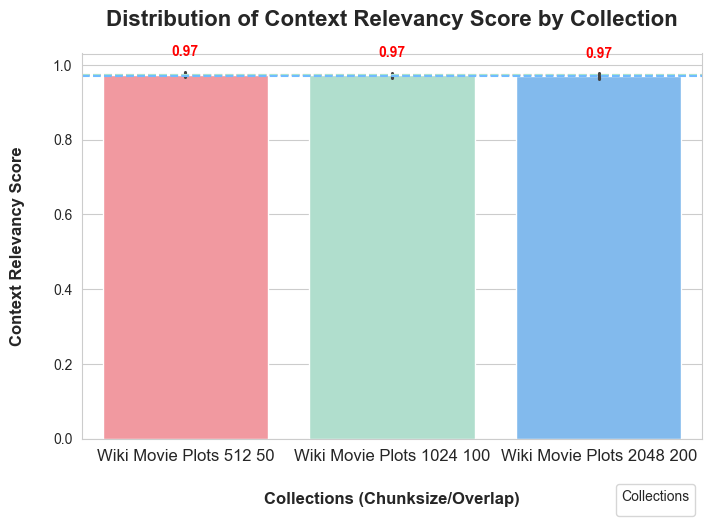

In [105]:
barplot_by_model_and_collection(
    df_combined_metric_a,
    metric_a,
    with_llms=False,
    x_label="Collections (Chunksize/Overlap)",
    width=8,
    height=5,
    reordered_colors=['red', 'red', 'red']
)

In [131]:
metric_b = 'correctness_score'

In [132]:
df_combined_metric_b = df_combined.copy()

In [133]:
df_combined_metric_b['count'] = df_combined_metric_b.groupby([metric_b]).cumcount()


In [134]:
df_combined_metric_b[['llm_model', 'collection_name', metric_b]].value_counts()

llm_model            collection_name                  correctness_score
oll_llama3_instruct  wiki_movie_plots_1024_100_mxbai  4.0                  113
oll_gemma_instruct   wiki_movie_plots_512_50_mxbai    3.0                  112
                     wiki_movie_plots_1024_100_mxbai  3.0                  103
                     wiki_movie_plots_2048_200_mxbai  3.0                  100
oll_llama3_instruct  wiki_movie_plots_2048_200_mxbai  4.0                   98
                                                                          ... 
                     wiki_movie_plots_1024_100_mxbai  2.5                    1
oll_gemma_instruct   wiki_movie_plots_512_50_mxbai    1.0                    1
oll_llama3_instruct  wiki_movie_plots_2048_200_mxbai  2.5                    1
                     wiki_movie_plots_512_50_mxbai    2.5                    1
oll_gemma_instruct   wiki_movie_plots_1024_100_mxbai  1.0                    1
Name: count, Length: 71, dtype: int64

Collection: wiki_movie_plots_512_50_mxbai
Collection: wiki_movie_plots_1024_100_mxbai
Collection: wiki_movie_plots_2048_200_mxbai


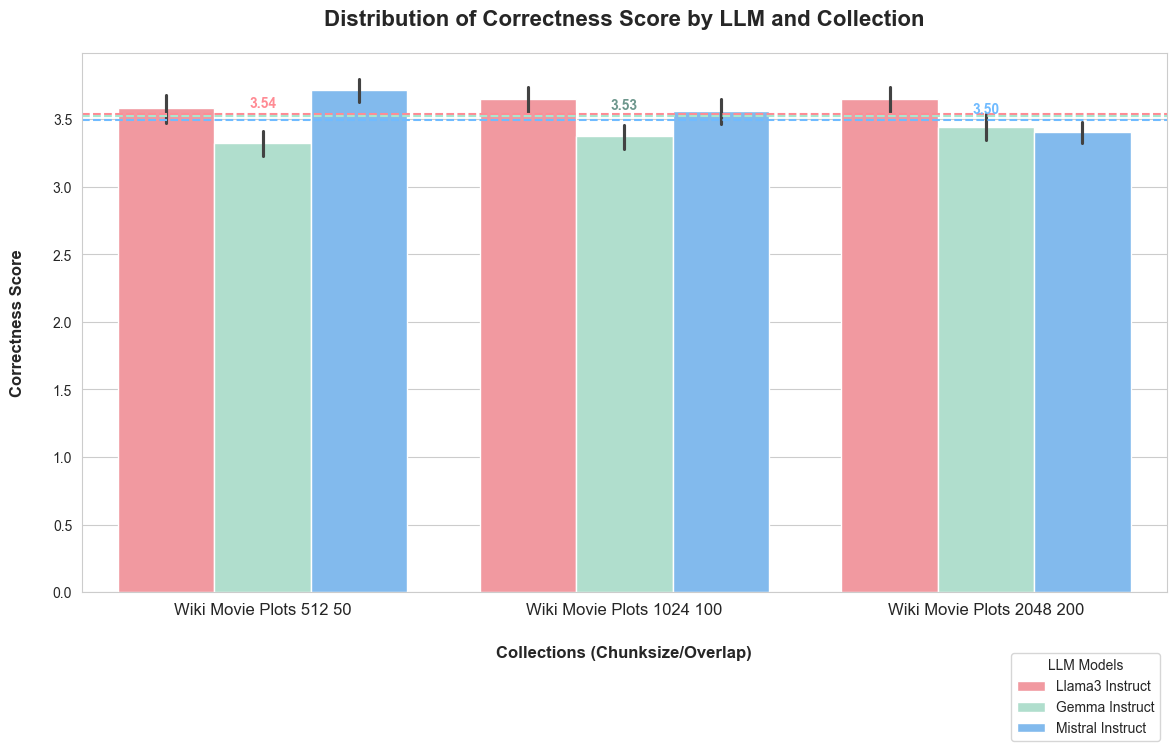

In [135]:
barplot_by_model_and_collection(
    df_combined_metric_b,
    metric_b,
    with_llms=True,
    x_label="Collections (Chunksize/Overlap)",
    width=14,
    height=7,
    reordered_colors=['#ff8b94', '#6d978d', '#70bbff']
)

In [136]:
metric_c = 'faithfulness_score'

In [137]:
df_combined_metric_c = df_combined.copy()

In [138]:
df_combined_metric_c

,llm_model,embed_model,collection_name,question_id,question,context,reference_answer,response,answer_feedback,context_relevancy_score,context_relevancy_feedback,correctness_score,correctness_feedback,faithfulness_score,relevancy_score,relevancy_feedback,model_score,model_feedback,chat_mode
0,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,0,"Who is the director of the movie ""The Karate K...",release_year: 1984\ntitle: The Karate Kid\nori...,"The director of the movie ""The Karate Kid"" rel...","According to the context information provided,...","1. Yes, the response matches the subject matte...",1.000,1. The retrieved context matches the subject m...,4.5,The generated answer is relevant and fully cor...,1.0,1.0,YES,1.0,Assistant A and Assistant B both correctly ide...,CONTEXT
1,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,1,"What is the plot of ""The Karate Kid"" released ...",release_year: 1984\ntitle: The Karate Kid\nori...,"The plot of ""The Karate Kid"" released in 1984 ...","According to the context information provided,...",1. Does the provided response match the subjec...,1.000,1. The retrieved context matches the subject m...,3.5,The generated answer provides a detailed summa...,1.0,1.0,YES,1.0,Assistant A provided a detailed and comprehens...,CONTEXT
2,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,2,"What is the genre of the movie ""The Karate Kid...",release_year: 1984\ntitle: The Karate Kid\nori...,"The genre of the movie ""The Karate Kid"" releas...","According to the context information provided,...",1. Does the provided response match the subjec...,1.000,1. The retrieved context matches the subject m...,4.5,The generated answer is relevant and fully cor...,0.0,1.0,YES,0.0,Assistant B provided a slightly better respons...,CONTEXT
3,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,3,Who was the legendary boxing trainer that took...,release_year: 2016\ntitle: Hands of Stone\nori...,"Ray Arcel, an American legendary boxing traine...","According to the context information provided,...",1. The response correctly identifies Ray Arcel...,1.000,1. The retrieved context matches the subject m...,4.5,The generated answer is highly relevant to the...,1.0,1.0,YES,1.0,Assistant A provided a direct and accurate res...,CONTEXT
4,oll_llama3_instruct,mxbai,wiki_movie_plots_512_50_mxbai,4,What was the result of the rematch between Rob...,release_year: 2016\ntitle: Hands of Stone\nori...,"Durán famously gave up by saying ""No más"" to t...","According to the context information provided,...",1. The response matches the subject matter of ...,1.000,1. The retrieved context matches the subject m...,4.5,The generated answer provides a detailed and a...,1.0,1.0,YES,1.0,Assistant A provided a more detailed and compr...,CONTEXT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,oll_mistral_instruct,mxbai,wiki_movie_plots_2048_200_mxbai,310,What is the main plot of Leviathan?,release_year: 1989\ntitle: Leviathan\norigin_e...,The main plot of Leviathan revolves around a c...,"The main plot of the film ""Leviathan,"" releas...",1. The response does not match the subject mat...,1.000,1. The retrieved context matches the subject m...,3.0,The generated answer provides a detailed summa...,1.0,0.0,NO,1.0,Assistant A provides a detailed and comprehens...,CONTEXT
2831,oll_mistral_instruct,mxbai,wiki_movie_plots_2048_200_mxbai,311,How does the film Leviathan end?,release_year: 1989\ntitle: Leviathan\norigin_e...,The film Leviathan ends with the survivors esc...,"In the film ""Leviathan,"" released in 1989, th...",1. The response provided does not match the su...,1.000,1. The retrieved context matches the subject m...,2.5,The generated answer provides a detailed summa...,1.0,0.0,NO,0.5,,CONTEXT
2832,oll_mistral_instruct,mxbai,wiki_movie_plots_2048_200_mxbai,312,"Who are the main characters in the movie ""The ...",release_year: 2002\ntitle: The Tuxedo\norigin_...,The main characters 

In [139]:
df_combined_metric_c_test_data = df_combined_metric_c.groupby(
    ['llm_model', 'collection_name', metric_c]).size().reset_index(name='count')
df_combined_metric_c_test_data_pivot = df_combined_metric_c_test_data.pivot(index=['llm_model', 'collection_name'],
                                                                            columns=metric_c,
                                                                            values='count').reset_index()
df_combined_metric_c_test_data.columns.name = None  # Remove the pivot table categorization
df_combined_metric_c_test_data.columns = ['llm_model', 'collection_name', 'count_0', 'count_1']
df_combined_metric_c_test_data_pivot.sort_values(by=[1.0], inplace=True)
df_combined_metric_c_test_data_pivot.reset_index(drop=True, inplace=True)
df_combined_metric_c_test_data_pivot

faithfulness_score,llm_model,collection_name,0.0,1.0
0,oll_llama3_instruct,wiki_movie_plots_512_50_mxbai,68,247
1,oll_llama3_instruct,wiki_movie_plots_2048_200_mxbai,65,250
2,oll_gemma_instruct,wiki_movie_plots_1024_100_mxbai,54,261
3,oll_gemma_instruct,wiki_movie_plots_2048_200_mxbai,40,275
4,oll_llama3_instruct,wiki_movie_plots_1024_100_mxbai,36,279
5,oll_gemma_instruct,wiki_movie_plots_512_50_mxbai,31,284
6,oll_mistral_instruct,wiki_movie_plots_1024_100_mxbai,22,293
7,oll_mistral_instruct,wiki_movie_plots_2048_200_mxbai,11,304
8,oll_mistral_instruct,wiki_movie_plots_512_50_mxbai,9,306


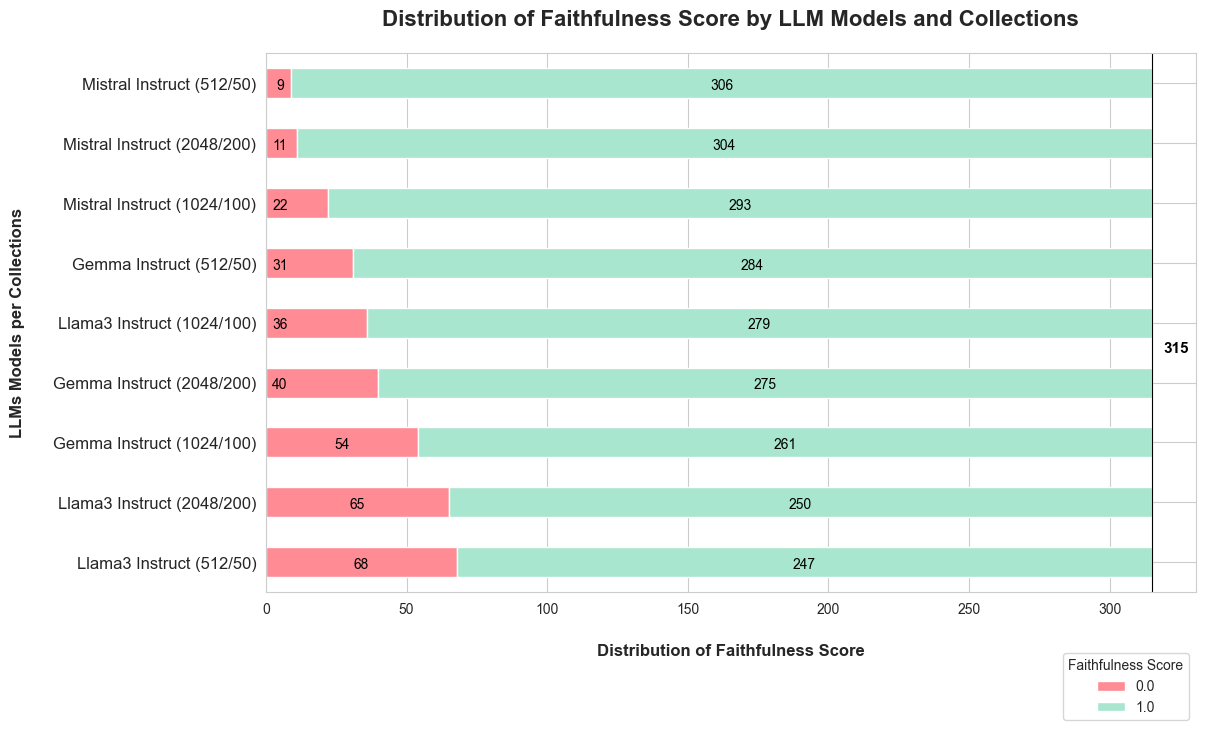

In [142]:
horizontal_barplot_by_model_and_collection(df_combined_metric_c_test_data_pivot, metric_c, x_label="Distribution of ", y_label="LLMs Models per Collections")

In [143]:
data_plot_metric_c = df_combined_metric_c[['collection_name', 'llm_model', metric_c]].value_counts()
data_plot_metric_c

collection_name                  llm_model             faithfulness_score
wiki_movie_plots_512_50_mxbai    oll_mistral_instruct  1.0                   306
wiki_movie_plots_2048_200_mxbai  oll_mistral_instruct  1.0                   304
wiki_movie_plots_1024_100_mxbai  oll_mistral_instruct  1.0                   293
wiki_movie_plots_512_50_mxbai    oll_gemma_instruct    1.0                   284
wiki_movie_plots_1024_100_mxbai  oll_llama3_instruct   1.0                   279
wiki_movie_plots_2048_200_mxbai  oll_gemma_instruct    1.0                   275
wiki_movie_plots_1024_100_mxbai  oll_gemma_instruct    1.0                   261
wiki_movie_plots_2048_200_mxbai  oll_llama3_instruct   1.0                   250
wiki_movie_plots_512_50_mxbai    oll_llama3_instruct   1.0                   247
                                                       0.0                    68
wiki_movie_plots_2048_200_mxbai  oll_llama3_instruct   0.0                    65
wiki_movie_plots_1024_100_mxbai  ol

In [144]:
df_combined_metric_c['count'] = df_combined_metric_c.groupby([metric_c]).cumcount() + 1

In [145]:
df_combined_metric_c[['llm_model', 'collection_name', metric_c]].value_counts()

llm_model             collection_name                  faithfulness_score
oll_mistral_instruct  wiki_movie_plots_512_50_mxbai    1.0                   306
                      wiki_movie_plots_2048_200_mxbai  1.0                   304
                      wiki_movie_plots_1024_100_mxbai  1.0                   293
oll_gemma_instruct    wiki_movie_plots_512_50_mxbai    1.0                   284
oll_llama3_instruct   wiki_movie_plots_1024_100_mxbai  1.0                   279
oll_gemma_instruct    wiki_movie_plots_2048_200_mxbai  1.0                   275
                      wiki_movie_plots_1024_100_mxbai  1.0                   261
oll_llama3_instruct   wiki_movie_plots_2048_200_mxbai  1.0                   250
                      wiki_movie_plots_512_50_mxbai    1.0                   247
                                                       0.0                    68
                      wiki_movie_plots_2048_200_mxbai  0.0                    65
oll_gemma_instruct    wiki_movie_pl

Collection: wiki_movie_plots_512_50_mxbai
Collection: wiki_movie_plots_1024_100_mxbai
Collection: wiki_movie_plots_2048_200_mxbai


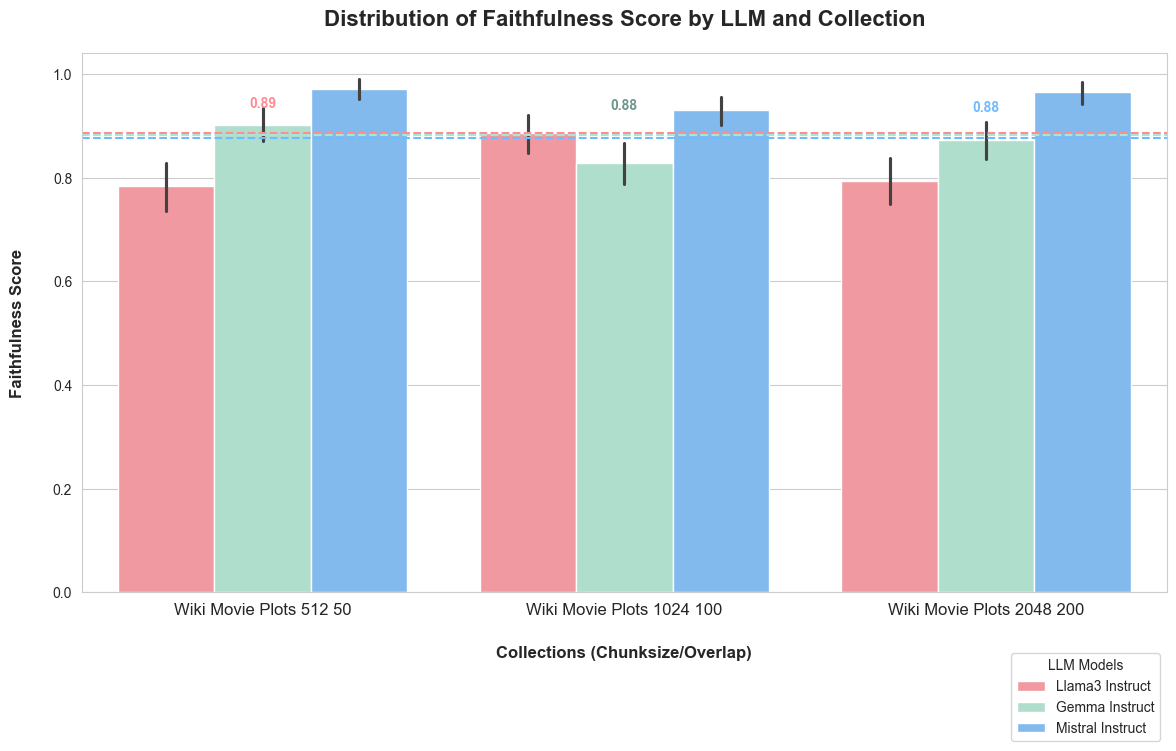

In [148]:
barplot_by_model_and_collection(df_combined_metric_c, metric_c, x_label="Collections (Chunksize/Overlap)", width=14, height=7, reordered_colors=['#ff8b94', '#6d978d', '#70bbff'])

In [149]:
metric_d = 'relevancy_score'

In [150]:
df_combined_metric_d = df_combined.copy()

In [151]:
df_combined_metric_d['count'] = df_combined_metric_d.groupby([metric_d]).cumcount()

In [152]:
df_combined_metric_d[['llm_model', 'collection_name', metric_d]].value_counts()

llm_model             collection_name                  relevancy_score
oll_mistral_instruct  wiki_movie_plots_512_50_mxbai    1.0                224
oll_gemma_instruct    wiki_movie_plots_2048_200_mxbai  1.0                213
                      wiki_movie_plots_512_50_mxbai    1.0                203
                      wiki_movie_plots_1024_100_mxbai  1.0                202
oll_llama3_instruct   wiki_movie_plots_1024_100_mxbai  1.0                191
                      wiki_movie_plots_2048_200_mxbai  1.0                191
oll_mistral_instruct  wiki_movie_plots_2048_200_mxbai  1.0                189
oll_llama3_instruct   wiki_movie_plots_512_50_mxbai    1.0                187
oll_mistral_instruct  wiki_movie_plots_1024_100_mxbai  1.0                174
                                                       0.0                141
oll_llama3_instruct   wiki_movie_plots_512_50_mxbai    0.0                128
oll_mistral_instruct  wiki_movie_plots_2048_200_mxbai  0.0             

In [153]:
df_combined_metric_d_test_data = df_combined_metric_d.groupby(
    ['llm_model', 'collection_name', metric_d]).size().reset_index(name='count')
df_combined_metric_d_test_data_pivot = df_combined_metric_d_test_data.pivot(index=['llm_model', 'collection_name'],
                                                                            columns=metric_d,
                                                                            values='count').reset_index()
df_combined_metric_d_test_data.columns.name = None  # Remove the pivot table categorization
df_combined_metric_d_test_data.columns = ['llm_model', 'collection_name', 'count_0', 'count_1']
df_combined_metric_d_test_data_pivot.sort_values(by=[1.0], inplace=True)
df_combined_metric_d_test_data_pivot.reset_index(drop=True, inplace=True)
df_combined_metric_d_test_data_pivot

relevancy_score,llm_model,collection_name,0.0,1.0
0,oll_mistral_instruct,wiki_movie_plots_1024_100_mxbai,141,174
1,oll_llama3_instruct,wiki_movie_plots_512_50_mxbai,128,187
2,oll_mistral_instruct,wiki_movie_plots_2048_200_mxbai,126,189
3,oll_llama3_instruct,wiki_movie_plots_1024_100_mxbai,124,191
4,oll_llama3_instruct,wiki_movie_plots_2048_200_mxbai,124,191
5,oll_gemma_instruct,wiki_movie_plots_1024_100_mxbai,113,202
6,oll_gemma_instruct,wiki_movie_plots_512_50_mxbai,112,203
7,oll_gemma_instruct,wiki_movie_plots_2048_200_mxbai,102,213
8,oll_mistral_instruct,wiki_movie_plots_512_50_mxbai,91,224


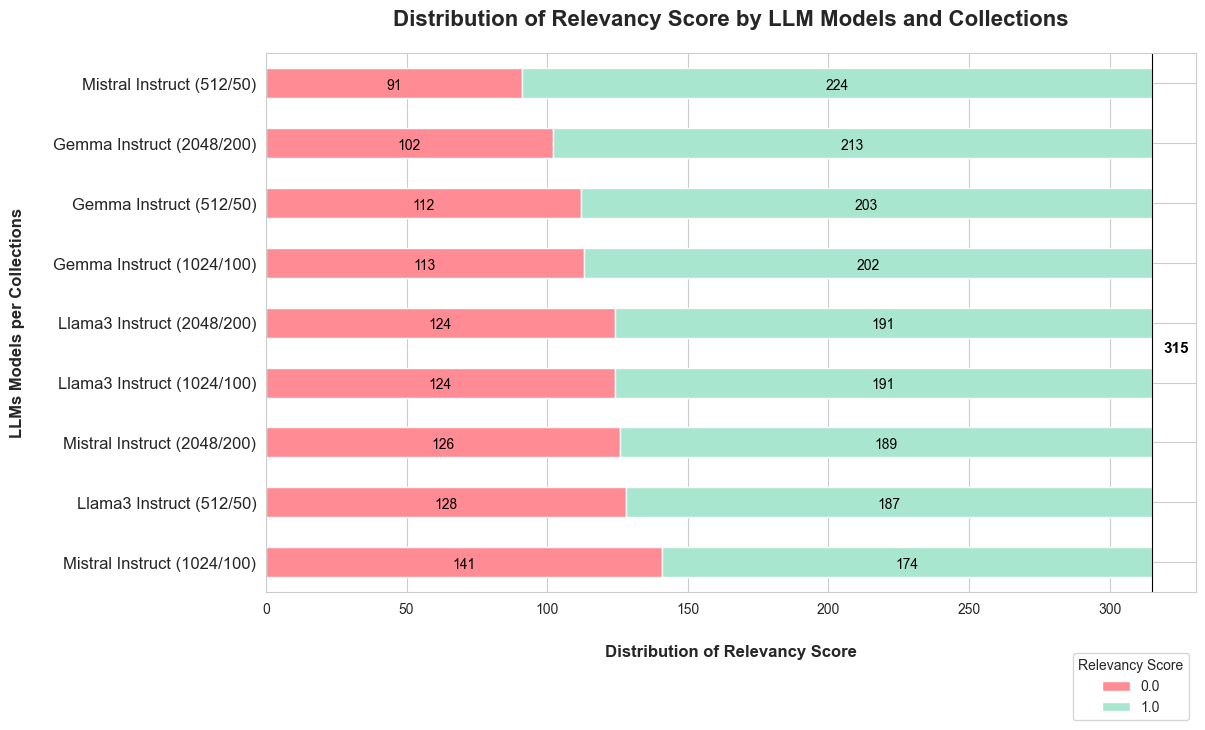

In [155]:
horizontal_barplot_by_model_and_collection(df_combined_metric_d_test_data_pivot, metric_d, x_label="Distribution of ", y_label="LLMs Models per Collections")

In [43]:
data_plot_metric_d = df_combined_metric_d[['collection_name', 'llm_model', metric_d]].value_counts()

Collection: wiki_movie_plots_512_50_mxbai
Collection: wiki_movie_plots_1024_100_mxbai
Collection: wiki_movie_plots_2048_200_mxbai


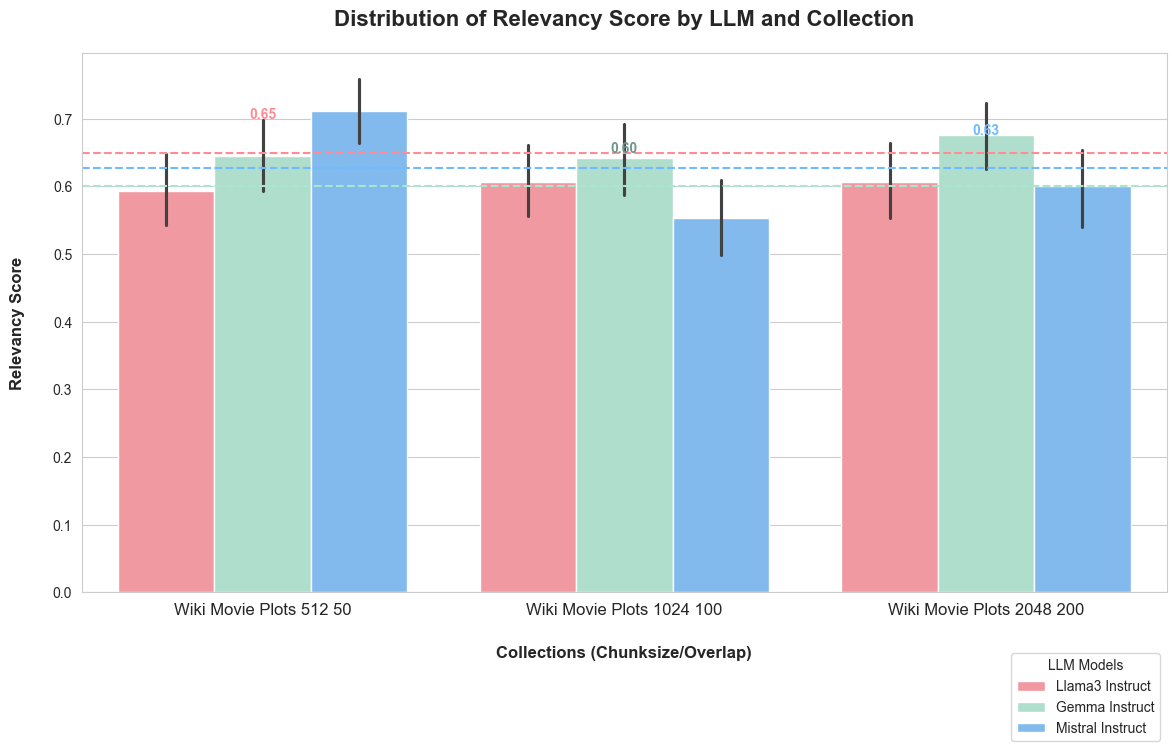

In [156]:
barplot_by_model_and_collection(df_combined_metric_d, metric_d, x_label="Collections (Chunksize/Overlap)", width=14, height=7, reordered_colors=['#ff8b94', '#6d978d', '#70bbff'])

In [45]:
metric_e = 'model_score'

In [46]:
df_combined_metric_e = df_combined.copy()

In [47]:
df_combined_metric_e['count'] = df_combined_metric_e.groupby([metric_e]).cumcount() + 1

In [48]:
df_combined_metric_e[['llm_model', 'collection_name', metric_e]].value_counts()

llm_model             collection_name                  model_score
oll_gemma_instruct    wiki_movie_plots_1024_100_mxbai  0.0            234
                      wiki_movie_plots_2048_200_mxbai  0.0            234
                      wiki_movie_plots_512_50_mxbai    0.0            215
oll_mistral_instruct  wiki_movie_plots_2048_200_mxbai  1.0            204
                      wiki_movie_plots_512_50_mxbai    1.0            188
                      wiki_movie_plots_1024_100_mxbai  1.0            151
oll_llama3_instruct   wiki_movie_plots_512_50_mxbai    0.0            127
                      wiki_movie_plots_2048_200_mxbai  0.0            124
                      wiki_movie_plots_1024_100_mxbai  0.0            119
                      wiki_movie_plots_2048_200_mxbai  1.0            109
                      wiki_movie_plots_1024_100_mxbai  1.0            108
                      wiki_movie_plots_512_50_mxbai    1.0             99
                                             

In [49]:
df_combined_metric_e[['llm_model', 'collection_name', metric_e]].value_counts()
df_combined_metric_e_test_data = df_combined_metric_e.groupby(
    ['llm_model', 'collection_name', metric_e]).size().reset_index(name='count')
df_combined_metric_e_test_data_pivot = df_combined_metric_e_test_data.pivot(index=['llm_model', 'collection_name'],
                                                                            columns=metric_e,
                                                                            values='count').reset_index()
df_combined_metric_e_test_data.columns.name = None  # Remove the pivot table categorization
df_combined_metric_e_test_data.columns = ['llm_model', 'collection_name', 'count_0', 'count_1']
df_combined_metric_e_test_data_pivot.sort_values(by=[1.0], inplace=True)
df_combined_metric_e_test_data_pivot.reset_index(drop=True, inplace=True)
df_combined_metric_e_test_data_pivot

model_score,llm_model,collection_name,0.0,0.5,1.0
0,oll_gemma_instruct,wiki_movie_plots_2048_200_mxbai,234,56,25
1,oll_gemma_instruct,wiki_movie_plots_1024_100_mxbai,234,50,31
2,oll_gemma_instruct,wiki_movie_plots_512_50_mxbai,215,62,38
3,oll_llama3_instruct,wiki_movie_plots_512_50_mxbai,127,89,99
4,oll_llama3_instruct,wiki_movie_plots_1024_100_mxbai,119,88,108
5,oll_llama3_instruct,wiki_movie_plots_2048_200_mxbai,124,82,109
6,oll_mistral_instruct,wiki_movie_plots_1024_100_mxbai,77,87,151
7,oll_mistral_instruct,wiki_movie_plots_512_50_mxbai,55,72,188
8,oll_mistral_instruct,wiki_movie_plots_2048_200_mxbai,73,38,204


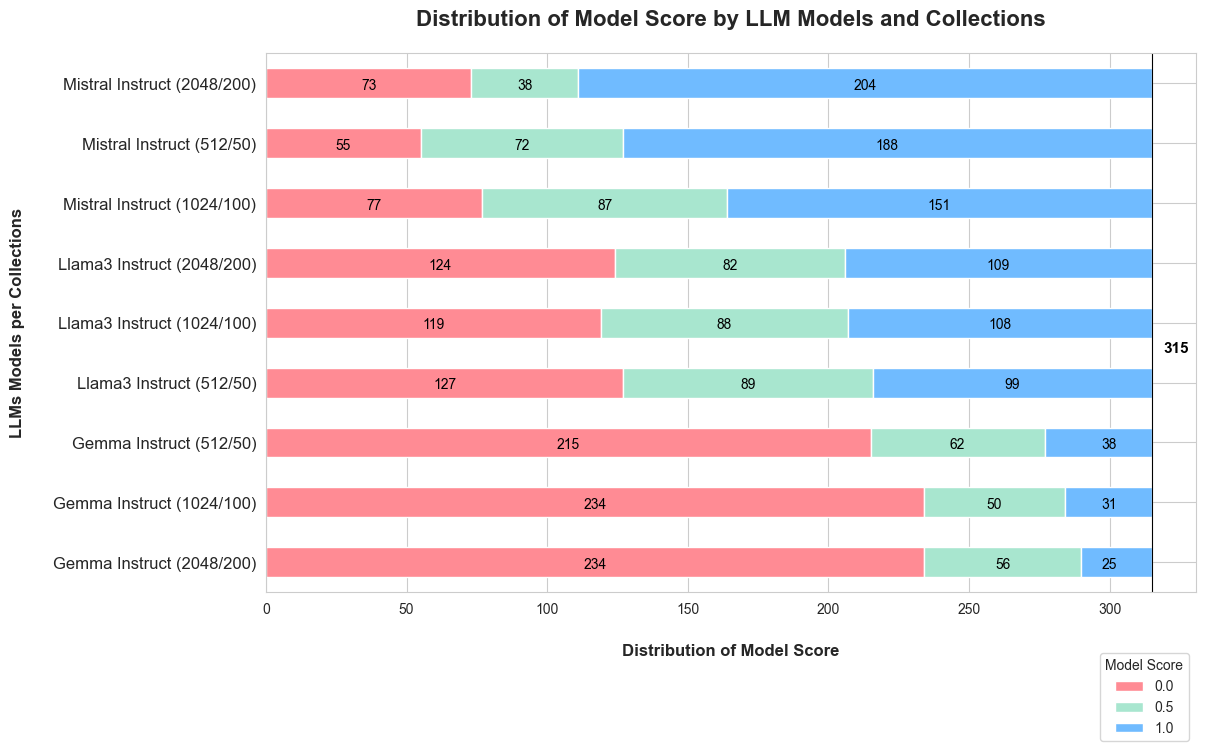

In [157]:
horizontal_barplot_by_model_and_collection(df_combined_metric_e_test_data_pivot, metric_e, x_label="Distribution of ", y_label="LLMs Models per Collections")

Collection: wiki_movie_plots_512_50_mxbai
Collection: wiki_movie_plots_1024_100_mxbai
Collection: wiki_movie_plots_2048_200_mxbai


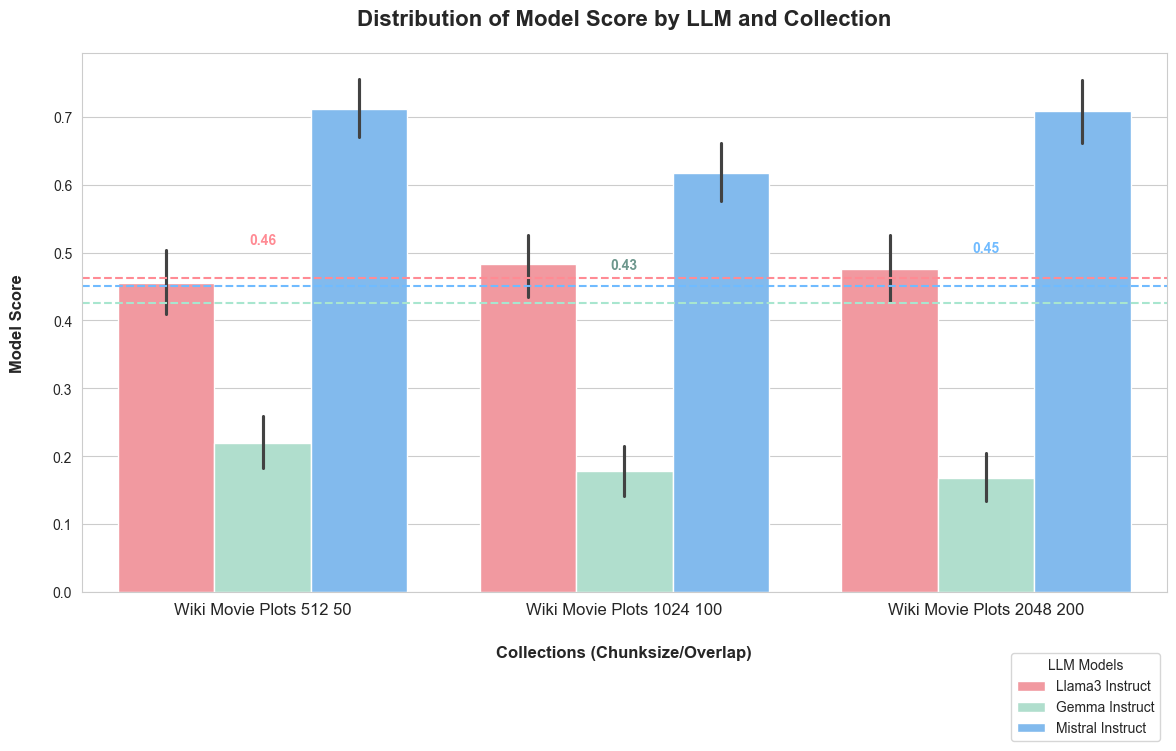

In [158]:
barplot_by_model_and_collection(df_combined_metric_e, metric_e, x_label="Collections (Chunksize/Overlap)", width=14, height=7, reordered_colors=['#ff8b94', '#6d978d', '#70bbff'])